In [1]:
from __future__ import division
from __future__ import print_function

import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
from scipy.stats import weibull_min
from numpy import percentile
# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.loci import LOCI
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.sos import SOS
from pyod.models.lscp import LSCP

import pandas as pd
from scipy import linalg
from scipy.stats import skew, kurtosis
from sklearn.metrics import pairwise_distances, f1_score
from tensorly.decomposition.robust_decomposition import robust_pca

from scipy.stats import skewnorm

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

In [2]:
def fit_m_rpca(data, m_reg_J=1):
    """
    Robust PCA based estimation of mean, covariance, skewness and kurtosis.

    :param data: MxN matrix with M observations and N features, where M>N
    :param m_reg_J: regularization. Default value is 1
    :return:
        L: array-like, shape (m_obserations, n_features,)
            Robust data

        rob_mean:
        rob_cov:
        rob_dist:
        rob_precision:
        rob_skew:
        rob_skew_dist:
        rob_kurt:
        rob_kurt_dist:
    """

    L, S = robust_pca(data, reg_J=m_reg_J)

    rob_mean = L.mean(axis=0)
    rob_cov = pd.DataFrame(L).cov()
    rob_precision = linalg.pinvh(rob_cov)
    rob_dist = (np.dot(L, rob_precision) * L).sum(axis=1)

    rob_skew = skew(L, axis=0, bias=True)
    rob_skew_dist = (np.dot(L - rob_skew, rob_precision) * (L - rob_skew)).sum(axis=1)

    rob_kurt = kurtosis(L, axis=0, fisher=True, bias=True)
    rob_kurt_dist = (np.dot(L - rob_kurt, rob_precision) * (L - rob_kurt)).sum(axis=1)

    return L, rob_mean, rob_cov, rob_dist, rob_precision, rob_skew, rob_skew_dist, rob_kurt, rob_kurt_dist


def cv_location_contamination(cv_df, cv_labels, location, precision):
    """

    :param cv_df: cross-validation data frame
    :param cv_labels: labels to evaluate prediction performance by contamination
    :param location: mean vector
    :param precision: inverse of covariance matrix
    :return: For all tested contamination rates, returns the rate in which the best F1-score were achieved.
    """

    contamination = round(0.00, 2)
    contamination_prediction_list = []
    labels = np.array(cv_labels)

    for i in range(40):
        contamination += 0.01
        contamination = round(contamination, 2)
        pred_label = predict_by_location_contamination(cv_df, location, precision, contamination)
        contamination_prediction_list.append((contamination, f1_score(labels, pred_label, average="binary")))

    contamination_prediction_list.sort(key=lambda tup: tup[1], reverse=True)
    contamination_best_f1 = contamination_prediction_list[0][0]

    return contamination_best_f1


def cv_location_threshold(cv_df, cv_labels, location, precision, dist):
    """

    :param cv_df: cross-validation data frame
    :param cv_labels: labels to evaluate prediction performance by contamination
    :param location:
    :param precision:
    :return: For all tested contamination rates, returns the rate in which the best F1-score were achieved.
    """

    threshold_prediction_list = []
    labels = np.array(cv_labels)
    min_dist = min(dist)
    max_dist = max(dist)

    for m_threshold in np.linspace(min_dist, max_dist, 40):
        pred_label = predict_by_location_threshold(cv_df, location, precision, m_threshold)
        threshold_prediction_list.append((m_threshold, f1_score(labels, pred_label, average="binary")))

    threshold_prediction_list.sort(key=lambda tup: tup[1], reverse=True)
    best_threshold = threshold_prediction_list[0][0]

    return best_threshold


def cv_skewness_contamination(cv_df, cv_labels, skewness, precision):
    """

    :param cv_df: cross-validation data frame
    :param cv_labels: labels to evaluate prediction performance by contamination
    :param skewness:
    :param precision:
    :return: For all tested contamination rates, returns the rate in which the best F1-score were achieved.
    """

    contamination = round(0.00, 2)
    contamination_prediction_list = []
    actual_anomalies = np.array(cv_labels)
    for i in range(40):
        contamination += 0.01
        contamination = round(contamination, 2)
        pred_label = predict_by_skewness_contamination(cv_df, precision, skewness, contamination)
        contamination_prediction_list.append((contamination, f1_score(actual_anomalies, pred_label, average="binary")))

    contamination_prediction_list.sort(key=lambda tup: tup[1], reverse=True)
    best_contamination = contamination_prediction_list[0][0]

    return best_contamination


def cv_skewness_threshold(cv_df, cv_labels, skewness, precision, skew_dist):
    """

    :param cv_df:
    :param cv_labels: labels to evaluate prediction performance by contamination
    :param skewness:
    :param precision:
    :param skew_dist:
    :return:
    """

    threshold_prediction_list = []
    actual_anomalies = np.array(cv_labels)
    min_dist = min(skew_dist)
    max_dist = max(skew_dist)

    for m_threshold in np.linspace(min_dist, max_dist, 40):
        pred_label = predict_by_skewness_threshold(cv_df, precision, skewness, m_threshold)
        threshold_prediction_list.append((m_threshold, f1_score(actual_anomalies, pred_label, average="binary")))

    threshold_prediction_list.sort(key=lambda tup: tup[1], reverse=True)
    best_threshold = threshold_prediction_list[0][0]

    return best_threshold


def cv_kurtosis_contamination(cv_df, cv_labels, m_kurtosis, precision):
    """

    :param df: cross-validation data frame
    :param location:
    :param precision:
    :return: For all tested contamination rates, returns the rate in which the best F1-score were achieved.
    """

    contamination = round(0.00, 2)
    contamination_prediction_list = []
    actual_anomalies = np.array(cv_labels)
    for i in range(40):
        contamination += 0.01
        contamination = round(contamination, 2)
        pred_label = predict_by_kurtosis_contamination(cv_df, precision, m_kurtosis, contamination)
        contamination_prediction_list.append((contamination, f1_score(actual_anomalies, pred_label, average="binary")))

    contamination_prediction_list.sort(key=lambda tup: tup[1], reverse=True)
    best_contamination = contamination_prediction_list[0][0]

    return best_contamination


def cv_kurtosis_threshold(cv_df, cv_labels, kurtosis, precision, kurt_dist):
    """

    :param cv_df:
    :param cv_labels: labels to evaluate prediction performance by contamination
    :param kurtosis:
    :param precision:
    :param kurt_dist:
    :return:
    """

    threshold_prediction_list = []
    actual_anomalies = np.array(cv_labels)
    min_dist = min(kurt_dist)
    max_dist = max(kurt_dist)

    for m_threshold in np.linspace(min_dist, max_dist, 40):
        pred_label = predict_by_kurtosis_threshold(cv_df, precision, kurtosis, m_threshold)
        threshold_prediction_list.append((m_threshold, f1_score(actual_anomalies, pred_label, average="binary")))

    threshold_prediction_list.sort(key=lambda tup: tup[1], reverse=True)
    best_threshold = threshold_prediction_list[0][0]

    return best_threshold


def md_rpca_prediction(test_df, location, precision, contamination):
    """

    :param test_df:
    :param location:
    :param precision:
    :param contamination:
    :return:
    """

    pred_label = np.full(test_df.shape[0], 0, dtype=int)
    if contamination is not None:
        # malhalanobis distance
        mahal_dist = pairwise_distances(test_df, location[np.newaxis, :], metric='mahalanobis', VI=precision)
        mahal_dist = np.reshape(mahal_dist, (len(test_df),)) ** 2  # MD squared
        # detect outliers
        contamination_threshold = np.percentile(mahal_dist, 100. * (1. - contamination))
        pred_label[mahal_dist > contamination_threshold] = 1
    else:
        raise NotImplementedError("You must provide a contamination rate.")

    return pred_label


def predict_by_location_centered_contamination(X, location, precision, contamination):
    """

    :param X:
    :param location:
    :param precision:
    :param contamination:
    :return:
    """

    pred_label = np.full(X.shape[0], 0, dtype=int)
    if contamination is not None:
        # malhalanobis distance
        X = X - location
        mahal_dist = pairwise_distances(X, location[np.newaxis, :], metric='mahalanobis', VI=precision)
        mahal_dist = np.reshape(mahal_dist, (len(X),)) ** 2  # MD squared
        # detect outliers
        contamination_threshold = np.percentile(mahal_dist, 100. * (1. - contamination))
        pred_label[mahal_dist > contamination_threshold] = 1
    else:
        raise NotImplementedError("You must provide a contamination rate.")

    return pred_label


def predict_by_location_threshold(X, location, precision, threshold):
    """

    :param X:
    :param location:
    :param precision:
    :param threshold:
    :return:
    """

    pred_label = np.full(X.shape[0], 0, dtype=int)

    # malhalanobis distance
    mahal_dist = pairwise_distances(X, location[np.newaxis, :], metric='mahalanobis', VI=precision)
    mahal_dist = np.reshape(mahal_dist, (len(X),)) ** 2  # MD squared
    # detect outliers
    pred_label[mahal_dist > threshold] = 1

    return pred_label


def sd_rpca_prediction(X, skewness, precision, contamination):
    """

    :param X:
    :param precision:
    :param skewness:
    :param contamination:
    :return:
    """

    pred_label = np.full(X.shape[0], 0, dtype=int)

    # malhalanobis distance
    mahal_dist = pairwise_distances(X, skewness[np.newaxis, :], metric='mahalanobis', VI=precision)
    mahal_dist = np.reshape(mahal_dist, (len(X),)) ** 2  # MD squared
    pred_skew_dist = -mahal_dist

    # detect outliers
    contamination_threshold = np.percentile(pred_skew_dist, 100. * contamination)
    pred_label[pred_skew_dist <= contamination_threshold] = 1

    return pred_label


def predict_by_skewness_centered_contamination(X, precision, skewness, contamination):
    """

    :param X:
    :param precision:
    :param skewness:
    :param contamination:
    :return:
    """

    pred_label = np.full(X.shape[0], 0, dtype=int)

    # skewness of the data
    X_skew = X - skew(X, axis=0, bias=True)

    # malhalanobis distance
    mahal_dist = pairwise_distances(X_skew, skewness[np.newaxis, :], metric='mahalanobis', VI=precision)
    mahal_dist = np.reshape(mahal_dist, (len(X_skew),)) ** 2  # MD squared
    pred_skew_dist = -mahal_dist

    # detect outliers
    contamination_threshold = np.percentile(pred_skew_dist, 100. * contamination)
    pred_label[pred_skew_dist <= contamination_threshold] = 1

    return pred_label


def predict_by_skewness_threshold(X, precision, skewness, threshold):
    """

    :param X:
    :param precision:
    :param skewness:
    :param threshold:
    :return:
    """

    pred_label = np.full(X.shape[0], 0, dtype=int)

    # malhalanobis distance
    mahal_dist = pairwise_distances(X, skewness[np.newaxis, :], metric='mahalanobis', VI=precision)
    mahal_dist = np.reshape(mahal_dist, (len(X),)) ** 2  # MD squared
    pred_skew_dist = -mahal_dist

    # detect outliers
    pred_label[pred_skew_dist <= threshold] = 1

    return pred_label


def predict_by_skewness_centered_threshold(X, precision, skewness, threshold):
    """

    :param X:
    :param precision:
    :param skewness:
    :param threshold:
    :return:
    """

    pred_label = np.full(X.shape[0], 0, dtype=int)

    # skewness of the data
    X_skew = X - skew(X, axis=0, bias=True)

    # malhalanobis distance
    mahal_dist = pairwise_distances(X_skew, skewness[np.newaxis, :], metric='mahalanobis', VI=precision)
    mahal_dist = np.reshape(mahal_dist, (len(X_skew),)) ** 2  # MD squared
    pred_skew_dist = -mahal_dist

    # detect outliers
    pred_label[pred_skew_dist <= threshold] = 1

    return pred_label


def kd_rpca_prediction(X, m_kurtosis, precision, contamination):
    """

    :param X:
    :param precision:
    :param m_kurtosis	:
    :param contamination:
    :return:
    """

    pred_label = np.full(X.shape[0], 0, dtype=int)

    # malhalanobis distance
    mahal_dist = pairwise_distances(X, m_kurtosis[np.newaxis, :], metric='mahalanobis', VI=precision)
    mahal_dist = np.reshape(mahal_dist, (len(X),)) ** 2  # MD squared
    pred_kurt_dist = -mahal_dist

    # detect outliers
    contamination_threshold = np.percentile(pred_kurt_dist, 100. * contamination)
    pred_label[pred_kurt_dist <= contamination_threshold] = 1

    return pred_label


def predict_by_kurtosis_centered_contamination(X, precision, m_kurtosis, contamination):
    """

    :param X:
    :param precision:
    :param m_kurtosis	:
    :param contamination:
    :return:
    """

    pred_label = np.full(X.shape[0], 0, dtype=int)

    # m_kurtosis	 of the data
    X_kurt = X - kurtosis(X, axis=0, bias=True)

    # malhalanobis distance
    mahal_dist = pairwise_distances(X_kurt, m_kurtosis[np.newaxis, :], metric='mahalanobis', VI=precision)
    mahal_dist = np.reshape(mahal_dist, (len(X_kurt),)) ** 2  # MD squared
    pred_kurt_dist = -mahal_dist

    # detect outliers
    contamination_threshold = np.percentile(pred_kurt_dist, 100. * contamination)
    pred_label[pred_kurt_dist <= contamination_threshold] = 1

    return pred_label


def predict_by_kurtosis_threshold(X, precision, m_kurtosis, threshold):
    """

    :param X:
    :param precision:
    :param m_kurtosis	:
    :param threshold:
    :return:
    """

    pred_label = np.full(X.shape[0], 0, dtype=int)

    # malhalanobis distance
    mahal_dist = pairwise_distances(X, m_kurtosis[np.newaxis, :], metric='mahalanobis', VI=precision)
    mahal_dist = np.reshape(mahal_dist, (len(X),)) ** 2  # MD squared
    pred_kurt_dist = -mahal_dist

    # detect outliers
    pred_label[pred_kurt_dist <= threshold] = 1

    return pred_label


def predict_by_kurtosis_centered_threshold(X, precision, m_kurtosis, threshold):
    """

    :param X:
    :param precision:
    :param m_kurtosis	:
    :param threshold:
    :return:
    """

    pred_label = np.full(X.shape[0], 0, dtype=int)

    # m_kurtosis	 of the data
    X_kurt = X - kurtosis(X, axis=0, bias=True)

    # malhalanobis distance
    mahal_dist = pairwise_distances(X_kurt, m_kurtosis[np.newaxis, :], metric='mahalanobis', VI=precision)
    mahal_dist = np.reshape(mahal_dist, (len(X_kurt),)) ** 2  # MD squared
    pred_kurt_dist = -mahal_dist

    # detect outliers
    pred_label[pred_kurt_dist <= threshold] = 1

    return pred_label

**Initialize values**

In [3]:
n_samples = 2400
# outliers_fraction = 0.33
# outliers_fraction = 0.25
outliers_fraction = 0.10

result_path = 'output/simulation/'
data_path = 'data/simulation/'

# Initialize the data
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(n_samples - n_inliers)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1  # put outliers into the end

print('n_samples:', n_samples)
print('n_inliers:', n_inliers)
print('n_outliers:', n_outliers)
print('ground_truth:', ground_truth.shape)

n_samples: 2400
n_inliers: 2160
n_outliers: 240
ground_truth: (2400,)


**Simulate Gaussian data for cases with and without outliers, for contaminated and normal training**

In [4]:
np.random.seed(11)
X1 = 0.3 * np.random.randn(n_inliers, 2)
X2 = 0.3 * np.random.randn(n_inliers, 2)
Xgaussian = np.r_[X1, X2]

Xgaussian_t = Xgaussian[:n_inliers]
Xgaussian = Xgaussian[n_inliers:]

**Simulate uniform outliers into Gaussian data**

In [5]:
# Append uniform outliers
Cuniform = np.random.uniform(low=-6, high=6, size=(n_outliers, 2))
Xgu = np.r_[Xgaussian, Cuniform]

Ctuniform = np.random.uniform(low=-6, high=6, size=(n_outliers, 2))
Xgaussian_tc = np.r_[Xgaussian_t, Ctuniform]

**Distribution plot of simulated Gaussian data**

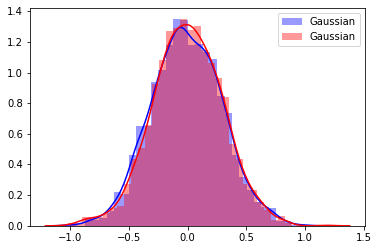

In [6]:
sns.distplot(Xgaussian[:, 0], color="blue", label="Gaussian")
sns.distplot(Xgaussian[:, 1], color="red", label="Gaussian")
plt.legend()
# plt.savefig("%sXgaussian.png" % result_path)
plt.show()
plt.close()

**Distribution plot of simulated Gaussian data**

Xgaussian_t: (2160, 2)


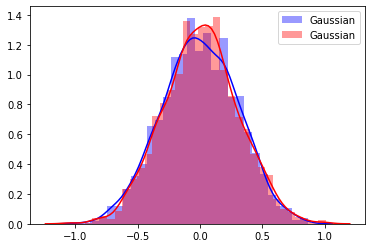

In [7]:
print('Xgaussian_t:', Xgaussian_t.shape)
sns.distplot(Xgaussian_t[:, 0], color="blue", label="Gaussian")
sns.distplot(Xgaussian_t[:, 1], color="red", label="Gaussian")
plt.legend()
# plt.savefig("%sXgaussian_t.png" % result_path)
plt.show()
plt.close()

**Distribution plot of simulated uniform data**

Cuniform: (240, 2)


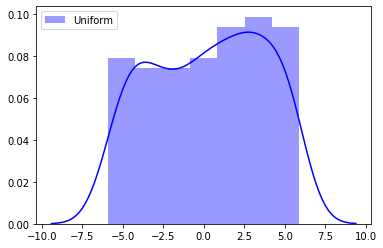

In [8]:
# Append outliers
print('Cuniform:', Cuniform.shape)
sns.distplot(Cuniform[:, 0], color="blue", label="Uniform")
plt.legend()
# plt.savefig("%sCuniform.png" % result_path)
plt.show()
plt.close()

**Distribution plot of simulated contaminated Gaussian data**

Xgu: (2400, 2)


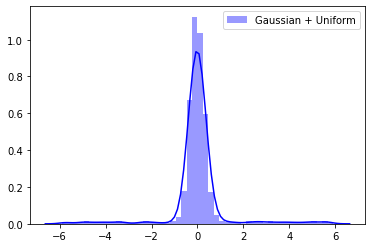

No handles with labels found to put in legend.


In [9]:
print('Xgu:', Xgu.shape)
sns.distplot(Xgu[:, 0], color="blue", label="Gaussian + Uniform")
plt.legend()
# plt.savefig("%sXgu.png" % result_path)
plt.show()
plt.legend()
plt.close()

**Distribution plot of simulated contaminated Gaussian data**

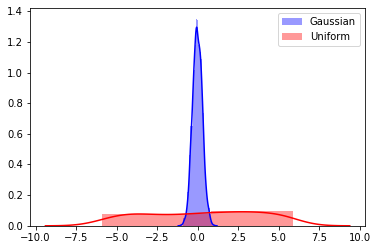

In [10]:
sns.distplot(Xgaussian[:, 0], color="blue", label="Gaussian")
sns.distplot(Cuniform[:, 0], color="red", label="Uniform")
plt.legend()
# plt.savefig("%sXgu2.png" % result_path)
plt.show()
plt.close()

**Define the selected classifiers for comparison**

In [11]:
random_state = np.random.RandomState(42)
classifiers = {    
    'Cluster-based Local Outlier Factor (CBLOF)': CBLOF(contamination=outliers_fraction, check_estimator=False,
                                                        random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction, random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
    'Local Outlier Factor (LOF)': LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(contamination=outliers_fraction, random_state=random_state)
}

**Evaluate the selected classifiers**

In [12]:
for i, (clf_name, clf) in enumerate(classifiers.items()):
    # fit the data and tag outliers
    clf.fit(Xgu)
    scores_pred = clf.decision_function(Xgu) * -1
    y_pred = clf.predict(Xgu)
    threshold = percentile(scores_pred, 100 * outliers_fraction)
    f1 = f1_score(ground_truth, y_pred, average="binary")
    print(i + 1, 'fitting', clf_name, f1)


1 fitting Cluster-based Local Outlier Factor (CBLOF) 0.975
2 fitting Histogram-base Outlier Detection (HBOS) 0.983050847457627
3 fitting Isolation Forest 0.9708333333333333
4 fitting K Nearest Neighbors (KNN) 0.9727463312368972
5 fitting Local Outlier Factor (LOF) 0.2923728813559322
6 fitting Minimum Covariance Determinant (MCD) 0.975
7 fitting One-class SVM (OCSVM) 0.975
8 fitting Principal Component Analysis (PCA) 0.9291666666666667


**Train m-RPCA from legitimate Gaussian, for semi-supervised anomaly detection**

In [13]:
r_L, r_mu, r_cov, r_dist, r_precision, r_skew, _, r_kurt, _ = fit_m_rpca(Xgaussian_t)

**Test md-RPCA for contaminated Gaussian**

In [14]:
# Testing md-rpca
md_pred_label = md_rpca_prediction(Xgu, r_mu, r_precision, outliers_fraction)
md_f1 = f1_score(ground_truth, md_pred_label, average="binary")
print('ss_md_rpca - F1: %6.2f' % (md_f1))

ss_md_rpca - F1:   0.97


**Test sd-RPCA for contaminated Gaussian**

In [15]:
# Testing sd-rpca
sd_pred_label = sd_rpca_prediction(Xgu, r_skew, r_precision, outliers_fraction)
sd_f1 = f1_score(ground_truth, sd_pred_label, average="binary")
print('ss_sd_rpca - F1: %6.2f' % (sd_f1))

ss_sd_rpca - F1:   0.97


**Test kd-RPCA for contaminated Gaussian**

In [16]:
# Testing kd-rpca
kd_pred_label = kd_rpca_prediction(Xgu, r_kurt, r_precision, outliers_fraction)
kd_f1 = f1_score(ground_truth, kd_pred_label, average="binary")
print('ss_kd_rpca - F1: %6.2f' % (kd_f1))

ss_kd_rpca - F1:   0.97


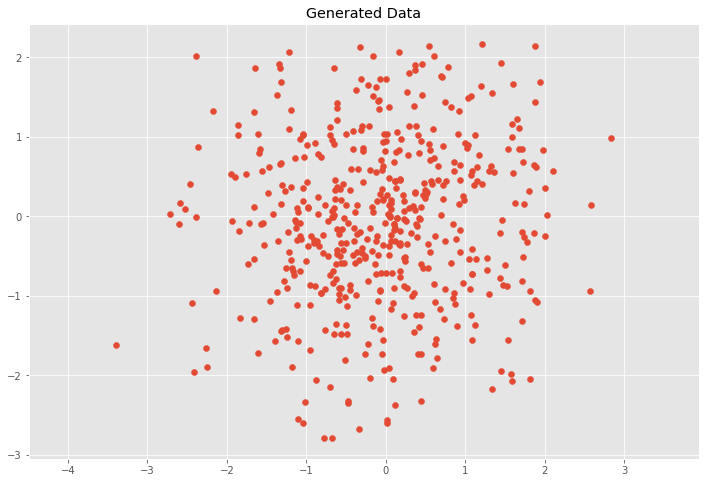

In [17]:
import numpy as np

# Normal distributed x and y vector with mean 0 and standard deviation 1
x = np.random.normal(0, 1, 500)
y = np.random.normal(0, 1, 500)
X = np.vstack((x, y)).T

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.scatter(X[:, 0], X[:, 1])
plt.title('Generated Data')
plt.axis('equal');

In [18]:
# Covariance
def cov(x, y):
    xbar, ybar = x.mean(), y.mean()
    return np.sum((x - xbar)*(y - ybar))/(len(x) - 1)

# Covariance matrix
def cov_mat(X):
    return np.array([[cov(X[0], X[0]), cov(X[0], X[1])], \
                     [cov(X[1], X[0]), cov(X[1], X[1])]])


In [19]:
cov_mat(X.T)

array([[1.05506456, 0.09343542],
       [0.09343542, 1.06931085]])

In [20]:
np.cov(X.T)

array([[1.05506456, 0.09343542],
       [0.09343542, 1.06931085]])

In [21]:
m = np.arange(10, dtype=np.float64)
print(m)

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [22]:
f = np.arange(10) * 2
print(f)

[ 0  2  4  6  8 10 12 14 16 18]


In [23]:
a = np.arange(10) ** 2.
print(a)

[ 0.  1.  4.  9. 16. 25. 36. 49. 64. 81.]


In [24]:
ddof = 9 # N - 1
w = f * a
print(w)

[   0.    2.   16.   54.  128.  250.  432.  686. 1024. 1458.]


In [25]:
v1 = np.sum(w)
print(v1)

4050.0


In [26]:
v2 = np.sum(w * a)
print(v2)

241650.0


In [27]:
m -= np.sum(m * w, axis=None, keepdims=True) / v1
print(m)

[-7.57185185 -6.57185185 -5.57185185 -4.57185185 -3.57185185 -2.57185185
 -1.57185185 -0.57185185  0.42814815  1.42814815]


In [28]:
cov = np.dot(m * w, m.T) * v1 / (v1**2 - ddof * v2)
print(cov)

2.6904614606066364


In [29]:
def tensor_cov(m, y=None, rowvar=True, bias=False, ddof=None, fweights=None,
        aweights=None):
    """
    Estimate a covariance matrix, given data and weights.
    Covariance indicates the level to which two variables vary together.
    If we examine N-dimensional samples, :math:`X = [x_1, x_2, ... x_N]^T`,
    then the covariance matrix element :math:`C_{ij}` is the covariance of
    :math:`x_i` and :math:`x_j`. The element :math:`C_{ii}` is the variance
    of :math:`x_i`.
    See the notes for an outline of the algorithm.
    Parameters
    ----------
    m : array_like
        A 1-D or 2-D array containing multiple variables and observations.
        Each row of `m` represents a variable, and each column a single
        observation of all those variables. Also see `rowvar` below.
    y : array_like, optional
        An additional set of variables and observations. `y` has the same form
        as that of `m`.
    rowvar : bool, optional
        If `rowvar` is True (default), then each row represents a
        variable, with observations in the columns. Otherwise, the relationship
        is transposed: each column represents a variable, while the rows
        contain observations.
    bias : bool, optional
        Default normalization (False) is by ``(N - 1)``, where ``N`` is the
        number of observations given (unbiased estimate). If `bias` is True,
        then normalization is by ``N``. These values can be overridden by using
        the keyword ``ddof`` in numpy versions >= 1.5.
    ddof : int, optional
        If not ``None`` the default value implied by `bias` is overridden.
        Note that ``ddof=1`` will return the unbiased estimate, even if both
        `fweights` and `aweights` are specified, and ``ddof=0`` will return
        the simple average. See the notes for the details. The default value
        is ``None``.
        .. versionadded:: 1.5
    fweights : array_like, int, optional
        1-D array of integer frequency weights; the number of times each
        observation vector should be repeated.
        .. versionadded:: 1.10
    aweights : array_like, optional
        1-D array of observation vector weights. These relative weights are
        typically large for observations considered "important" and smaller for
        observations considered less "important". If ``ddof=0`` the array of
        weights can be used to assign probabilities to observation vectors.
        .. versionadded:: 1.10
    Returns
    -------
    out : ndarray
        The covariance matrix of the variables.
    See Also
    --------
    corrcoef : Normalized covariance matrix
    Notes
    -----
    Assume that the observations are in the columns of the observation
    array `m` and let ``f = fweights`` and ``a = aweights`` for brevity. The
    steps to compute the weighted covariance are as follows::
        >>> m = np.arange(10, dtype=np.float64)
        >>> f = np.arange(10) * 2
        >>> a = np.arange(10) ** 2.
        >>> ddof = 9 # N - 1
        >>> w = f * a
        >>> v1 = np.sum(w)
        >>> v2 = np.sum(w * a)
        >>> m -= np.sum(m * w, axis=None, keepdims=True) / v1
        >>> cov = np.dot(m * w, m.T) * v1 / (v1**2 - ddof * v2)
    Note that when ``a == 1``, the normalization factor
    ``v1 / (v1**2 - ddof * v2)`` goes over to ``1 / (np.sum(f) - ddof)``
    as it should.
    Examples
    --------
    Consider two variables, :math:`x_0` and :math:`x_1`, which
    correlate perfectly, but in opposite directions:
    >>> x = np.array([[0, 2], [1, 1], [2, 0]]).T
    >>> x
    array([[0, 1, 2],
           [2, 1, 0]])
    Note how :math:`x_0` increases while :math:`x_1` decreases. The covariance
    matrix shows this clearly:
    >>> np.cov(x)
    array([[ 1., -1.],
           [-1.,  1.]])
    Note that element :math:`C_{0,1}`, which shows the correlation between
    :math:`x_0` and :math:`x_1`, is negative.
    Further, note how `x` and `y` are combined:
    >>> x = [-2.1, -1,  4.3]
    >>> y = [3,  1.1,  0.12]
    >>> X = np.stack((x, y), axis=0)
    >>> np.cov(X)
    array([[11.71      , -4.286     ], # may vary
           [-4.286     ,  2.144133]])
    >>> np.cov(x, y)
    array([[11.71      , -4.286     ], # may vary
           [-4.286     ,  2.144133]])
    >>> np.cov(x)
    array(11.71)
    """
    # Check inputs
    if ddof is not None and ddof != int(ddof):
        raise ValueError(
            "ddof must be integer")

    # Handles complex arrays too
    m = np.asarray(m)
    if m.ndim > 2:
        raise ValueError("m has more than 2 dimensions")

    if y is None:
        dtype = np.result_type(m, np.float64)
    else:
        y = np.asarray(y)
        if y.ndim > 2:
            raise ValueError("y has more than 2 dimensions")
        dtype = np.result_type(m, y, np.float64)

    X = array(m, ndmin=2, dtype=dtype)
    if not rowvar and X.shape[0] != 1:
        X = X.T
    if X.shape[0] == 0:
        return np.array([]).reshape(0, 0)
    if y is not None:
        y = array(y, copy=False, ndmin=2, dtype=dtype)
        if not rowvar and y.shape[0] != 1:
            y = y.T
        X = np.concatenate((X, y), axis=0)

    if ddof is None:
        if bias == 0:
            ddof = 1
        else:
            ddof = 0

    # Get the product of frequencies and weights
    w = None
    if fweights is not None:
        fweights = np.asarray(fweights, dtype=float)
        if not np.all(fweights == np.around(fweights)):
            raise TypeError(
                "fweights must be integer")
        if fweights.ndim > 1:
            raise RuntimeError(
                "cannot handle multidimensional fweights")
        if fweights.shape[0] != X.shape[1]:
            raise RuntimeError(
                "incompatible numbers of samples and fweights")
        if any(fweights < 0):
            raise ValueError(
                "fweights cannot be negative")
        w = fweights
    if aweights is not None:
        aweights = np.asarray(aweights, dtype=float)
        if aweights.ndim > 1:
            raise RuntimeError(
                "cannot handle multidimensional aweights")
        if aweights.shape[0] != X.shape[1]:
            raise RuntimeError(
                "incompatible numbers of samples and aweights")
        if any(aweights < 0):
            raise ValueError(
                "aweights cannot be negative")
        if w is None:
            w = aweights
        else:
            w *= aweights

    avg, w_sum = average(X, axis=1, weights=w, returned=True)
    w_sum = w_sum[0]

    # Determine the normalization
    if w is None:
        fact = X.shape[1] - ddof
    elif ddof == 0:
        fact = w_sum
    elif aweights is None:
        fact = w_sum - ddof
    else:
        fact = w_sum - ddof*sum(w*aweights)/w_sum

    if fact <= 0:
        warnings.warn("Degrees of freedom <= 0 for slice",
                      RuntimeWarning, stacklevel=3)
        fact = 0.0

    X -= avg[:, None]
    if w is None:
        X_T = X.T
    else:
        X_T = (X*w).T
    c = dot(X, X_T.conj())
    c *= np.true_divide(1, fact)
    return c.squeeze()

**Train size**

In [30]:
Xgaussian_t.shape

(2160, 2)

**Test size**

In [31]:
Xgu.shape

(2400, 2)

In [32]:
Xgaussian_tc.shape

(2400, 2)

In [33]:
from tensorly import fold, unfold

In [34]:
Xgu[0:24,:]

array([[ 0.21809586, -0.12089806],
       [ 0.13150888,  0.2562235 ],
       [-0.61041875, -0.19740743],
       [ 0.11773663,  0.01818286],
       [-0.42141444, -0.17220399],
       [-0.0450637 , -0.13845499],
       [ 0.16240492,  0.47013477],
       [ 0.15461048, -0.39655946],
       [-0.30059502,  0.19298907],
       [ 0.29087896, -0.21771308],
       [-0.17626664, -0.6842647 ],
       [ 0.36295128, -0.02653906],
       [-0.1628999 ,  0.20335003],
       [ 0.12379592,  0.39892881],
       [-0.27653214,  0.04977453],
       [-0.31816626, -0.00658874],
       [-0.16087051, -0.43786873],
       [-0.3058444 ,  0.15614044],
       [-0.23641058, -0.02629352],
       [-0.70469786,  0.09350002],
       [-0.75577469, -0.15847842],
       [ 0.03490129,  0.64594749],
       [ 0.07026094, -0.28048965],
       [-0.15733691,  0.08842423]])

In [35]:
Xgu2 = fold(Xgu, 2, (24, 2, 100))
print(Xgu2.shape)
print(Xgu2[...,0])

(24, 2, 100)
[[ 0.21809586 -0.12089806]
 [ 0.13150888  0.2562235 ]
 [-0.61041875 -0.19740743]
 [ 0.11773663  0.01818286]
 [-0.42141444 -0.17220399]
 [-0.0450637  -0.13845499]
 [ 0.16240492  0.47013477]
 [ 0.15461048 -0.39655946]
 [-0.30059502  0.19298907]
 [ 0.29087896 -0.21771308]
 [-0.17626664 -0.6842647 ]
 [ 0.36295128 -0.02653906]
 [-0.1628999   0.20335003]
 [ 0.12379592  0.39892881]
 [-0.27653214  0.04977453]
 [-0.31816626 -0.00658874]
 [-0.16087051 -0.43786873]
 [-0.3058444   0.15614044]
 [-0.23641058 -0.02629352]
 [-0.70469786  0.09350002]
 [-0.75577469 -0.15847842]
 [ 0.03490129  0.64594749]
 [ 0.07026094 -0.28048965]
 [-0.15733691  0.08842423]]


In [36]:
L2, S2 = robust_pca(Xgu2, reg_J=1)

In [37]:
L2.shape

(24, 2, 100)

In [39]:
uL = unfold(L2, 1)

In [40]:
uL.shape

(2, 2400)

In [41]:
rob_mean = L.mean(axis=0)
rob_cov = pd.DataFrame(L).cov()
rob_precision = linalg.pinvh(rob_cov)
rob_dist = (np.dot(L, rob_precision) * L).sum(axis=1)

rob_skew = skew(L, axis=0, bias=True)
rob_skew_dist = (np.dot(L - rob_skew, rob_precision) * (L - rob_skew)).sum(axis=1)

rob_kurt = kurtosis(L, axis=0, fisher=True, bias=True)
rob_kurt_dist = (np.dot(L - rob_kurt, rob_precision) * (L - rob_kurt)).sum(axis=1)

return L, rob_mean, rob_cov, rob_dist, rob_precision, rob_skew, rob_skew_dist, rob_kurt, rob_kurt_dist

NameError: name 'L' is not defined

In [42]:
import tensorly as tl
X = tl.tensor(np.arange(24).reshape((4, 3, 2)))

In [43]:
X.shape

(4, 3, 2)

In [44]:
np.set_printoptions(precision=3)
print(X)

[[[ 0  1]
  [ 2  3]
  [ 4  5]]

 [[ 6  7]
  [ 8  9]
  [10 11]]

 [[12 13]
  [14 15]
  [16 17]]

 [[18 19]
  [20 21]
  [22 23]]]


In [45]:
X[..., 0]

array([[ 0,  2,  4],
       [ 6,  8, 10],
       [12, 14, 16],
       [18, 20, 22]])

In [46]:
X[..., 1]

array([[ 1,  3,  5],
       [ 7,  9, 11],
       [13, 15, 17],
       [19, 21, 23]])

**mode-1 unfolding**

In [47]:
X1 = unfold(X, 0)
print(X1)
print(X1.shape)

[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]]
(4, 6)


**mode-2 unfolding**

In [48]:
X2 = unfold(X, 1)
print(X2)
print(X2.shape)

[[ 0  1  6  7 12 13 18 19]
 [ 2  3  8  9 14 15 20 21]
 [ 4  5 10 11 16 17 22 23]]
(3, 8)


**mode-3 unfolding**

In [49]:
X3 = unfold(X, 2)
print(X3)
print(X3.shape)

[[ 0  2  4  6  8 10 12 14 16 18 20 22]
 [ 1  3  5  7  9 11 13 15 17 19 21 23]]
(2, 12)


In [50]:
fold(X1, 0, (4, 3, 2))

array([[[ 0,  1],
        [ 2,  3],
        [ 4,  5]],

       [[ 6,  7],
        [ 8,  9],
        [10, 11]],

       [[12, 13],
        [14, 15],
        [16, 17]],

       [[18, 19],
        [20, 21],
        [22, 23]]])

In [51]:
fold(X1, 1, (4, 3, 2))

array([[[ 0,  1],
        [ 8,  9],
        [16, 17]],

       [[ 2,  3],
        [10, 11],
        [18, 19]],

       [[ 4,  5],
        [12, 13],
        [20, 21]],

       [[ 6,  7],
        [14, 15],
        [22, 23]]])

In [52]:
fold(X1, 2, (4, 3, 2))

array([[[ 0, 12],
        [ 1, 13],
        [ 2, 14]],

       [[ 3, 15],
        [ 4, 16],
        [ 5, 17]],

       [[ 6, 18],
        [ 7, 19],
        [ 8, 20]],

       [[ 9, 21],
        [10, 22],
        [11, 23]]])

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import FactorAnalysis, PCA
import tensortools as tt
from tensortools.operations import unfold as tt_unfold, khatri_rao
import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac

# import some useful functions (they are available in utils.py)
from utils import *

In [60]:
time_factor = np.load("data/tensor-decomposition-in-python/time_factor.npy")
neuron_factor = np.load("data/tensor-decomposition-in-python/neuron_factor.npy")
trial_factor = np.load("data/tensor-decomposition-in-python/trial_factor.npy")
latent = np.load("data/tensor-decomposition-in-python/latent.npy")
observed = np.load("data/tensor-decomposition-in-python/observed.npy")

# Specify the tensor, and the rank (np. of factors)
X, rank = observed, 3

In [61]:
print(observed.shape)

(500, 50, 100)


In [62]:
# Perform CP decompositon using TensorLy
factors_tl = parafac(X, rank=rank)

In [63]:
# Perform CP decomposition using tensortools
U = tt.cp_als(X, rank=rank, verbose=False)
factors_tt = U.factors.factors

In [64]:
# Reconstruct M, with the result of each library
M_tt = reconstruct(factors_tt)
M_tl = reconstruct(factors_tl)

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
# plot the decomposed factors
plot_factors(factors_tl)
plot_factors(factors_tt)

In [ ]:
def decompose_three_way(tensor, rank, max_iter=501, verbose=False):

    # a = np.random.random((rank, tensor.shape[0]))
    b = np.random.random((rank, tensor.shape[1]))
    c = np.random.random((rank, tensor.shape[2]))

    for epoch in range(max_iter):
        # optimize a
        input_a = khatri_rao([b.T, c.T])
        target_a = tl.unfold(tensor, mode=0).T
        a = np.linalg.solve(input_a.T.dot(input_a), input_a.T.dot(target_a))

        # optimize b
        input_b = khatri_rao([a.T, c.T])
        target_b = tl.unfold(tensor, mode=1).T
        b = np.linalg.solve(input_b.T.dot(input_b), input_b.T.dot(target_b))

        # optimize c
        input_c = khatri_rao([a.T, b.T])
        target_c = tl.unfold(tensor, mode=2).T
        c = np.linalg.solve(input_c.T.dot(input_c), input_c.T.dot(target_c))

        if verbose and epoch % int(max_iter * .2) == 0:
            res_a = np.square(input_a.dot(a) - target_a)
            res_b = np.square(input_b.dot(b) - target_b)
            res_c = np.square(input_c.dot(c) - target_c)
            print("Epoch:", epoch, "| Loss (C):", res_a.mean(), "| Loss (B):", res_b.mean(), "| Loss (C):", res_c.mean())

    return a.T, b.T, c.T